In [3]:
from dask_gateway import Gateway
from dask.distributed import Client
gateway = Gateway()
cluster = gateway.new_cluster()
cluster.adapt(minimum=2, maximum=100)
client = Client(cluster)
cluster

In [1]:
!pip install --upgrade git+https://github.com/JiaweiZhuang/xESMF.git

  Cloning https://github.com/JiaweiZhuang/xESMF.git to /tmp/pip-req-build-l_22ebka
  Running command git clone -q https://github.com/JiaweiZhuang/xESMF.git /tmp/pip-req-build-l_22ebka
  Created wheel for xesmf: filename=xesmf-0.3.0-py3-none-any.whl size=20079 sha256=94c1c8f755b7746183ffd2e491caca20d98fa09618768bb16252dcce88b360ea
  Stored in directory: /tmp/pip-ephem-wheel-cache-snnsp32s/wheels/d7/d9/36/77fa4453320fcc02ae0c467f668d1583e9fcbea536c2aaf287
Successfully built xesmf
  Attempting uninstall: xesmf
    Found existing installation: xesmf 0.3.0
    Uninstalling xesmf-0.3.0:
      Successfully uninstalled xesmf-0.3.0


In [4]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
import gcsfs # Pythonic file-system for Google Cloud Storage
import xesmf as xe
import cartopy.crs as ccrs
import cartopy.feature as cfeature


%matplotlib inline

In [5]:
def get_data(df, var, model, expe, freq):
    try:
        uri = df[(df.variable_id == var) & \
                 (df.source_id == model) & \
                 (df.experiment_id == expe) & \
                 (df.table_id == freq)].zstore.values[0]
        gcs = gcsfs.GCSFileSystem(token='anon')
        ds = xr.open_zarr(gcs.get_mapper(uri), consolidated=True)
    except:
        ds = []
        print(model, ": no data")
    return ds    
   

In [84]:
# version from Github

df = pd.read_csv('https://storage.googleapis.com/cmip6/cmip6-zarr-consolidated-stores.csv')
# Chage order
#models = ['GFDL-CM4', 'GFDL-ESM4',  'GISS-E2-1-G', 'GISS-E2-1-G-CC', 'IPSL-CM6A-LR',
#          'MIROC-ES2L', 'MPI-ESM1-2-HR', 'MRI-ESM2-0', 'NorCPM1', 'NorESM2-LM', 
#          'UKESM1-0-LL', 'CanESM5', 'CESM2', 'CESM2-WACCM', 'CNRM-ESM2-1']
# models = ['CESM2', 'CESM2-WACCM', 'GFDL-CM4', 'GFDL-ESM4', 'IPSL-CM6A-LR',  
#           'MRI-ESM2-0','GISS-E2-1-G', 'GISS-E2-1-G-CC', 'MIROC-ES2L','CanESM5',
#            'NorCPM1', 'NorESM2-LM', 'MPI-ESM1-2-HR', 'UKESM1-0-LL', 'CNRM-ESM2-1']
# list of all the models on pnageo with Omon, ssp585
# models = ['AWI-CM-1-1-MR','BCC-CSM2-MR','CAMS-CSM1-0','CanESM5-CanOE','CanESM5',
#           'CMCC-CM2-SR5','CNRM-CM6-1','CNRM-ESM2-1','ACCESS-CM2','ACCESS-ESM1-5',
#           'MPI-ESM1-2-HR','EC-Earth3-Veg','EC-Earth3', 'FIO-ESM-2-0','IPSL-CM6A-LR',
#           'MIROC-ES2L','MIROC6','HadGEM3-GC31-LL','HadGEM3-GC31-MM','UKESM1-0-LL',
#           'MPI-ESM1-2-LR','MRI-ESM2-0','CESM2-WACCM','NorESM2-LM', 'NorESM2-MM',
#           'GFDL-CM4','GFDL-ESM4','NESM3','CIESM','MCM-UA-1-0']

models = ['CESM2-WACCM','GFDL-CM4','GFDL-ESM4','IPSL-CM6A-LR', 'MRI-ESM2-0',
          'HadGEM3-GC31-LL','HadGEM3-GC31-MM', 'CanESM5-CanOE','CanESM5', 'NorESM2-LM', 
          'NorESM2-MM','MPI-ESM1-2-LR','MPI-ESM1-2-HR', 'AWI-CM-1-1-MR','BCC-CSM2-MR',
          'CAMS-CSM1-0', 'CMCC-CM2-SR5','CNRM-CM6-1','CNRM-ESM2-1', 'ACCESS-CM2',
          'ACCESS-ESM1-5','EC-Earth3-Veg','EC-Earth3', 'FIO-ESM-2-0','MIROC-ES2L',
          'MIROC6','UKESM1-0-LL','NESM3','CIESM','MCM-UA-1-0']

# var_names=['Phyc_allmonths','Chl_allmonths','Phydiat_allmonths','Zooc_allmonths','Zoo_by_Phyto','PPint_allmonths','EPC100_allmonths','FgCO2_allmonths','SpCO2_allmonths','Fe_allmonths','NO3_allmonths','Si_allmonths','SST_allmonths', 'MLD_allmonths', 'HFDS_allmonths','SpCO2_T', 'SpCO2_nonT']
# plot_titles=['Biomass (mol/m3)','Chlorophyll (kg.m-3)','Diatom (mol/m3)', 'Zooplankton (mol/m3)', 'Zoop/Phyto (-)','Primary Production (mol.m-2.s-1)','Export Production at 100m (mol.m-2.s-1)','Air-sea CO2 flux (donward +) (gram C /m2/year)','Surface pCO2 (ppm)', 'Iron - Fe (mol/m3)', 'Nitrate - NO3 (mol/m3)','Silica - Si (mol/m3)', 'Sea Surface Temperature (C)', 'Mixed Layer Depth (m)', 'Downward Heat Flux at Sea Water Surface (W.m-2)', 'pCO2-T (ppm)', 'pCO2-nonT (ppm)'                                   ]  
# file_names=['bio',  'bio',   'bio',    'bio',     'bio',   'bio',  'bio',   'bio',   'bio',   'bio',   'bio',  'bio', 'physics', 'physics', 'physics',   'bio',  'bio'  ]
# save_names= [ 'Phyc','Chl', 'Phydiat', 'Zooc', 'ZoobyPhyto', 'PPint','EPC100', 'FgCO2', 'SpCO2', 'Fe', 'NO3', 'Si', 'SST', 'MLD', 'HFDS' , 'SpCO2_Temp', 'SpCO2_nonT'   ]  
# plot_ranges=[[0,0.006], [0,8e-7],  [0, 0.0008],  [0,0.006],  [0,2], [0,1e-6], [0,1.6e-7],   [-12,12],   [300,450],    [0,3.8e-6], [0,0.015], [0,0.06], [0,32], [0,300], [-120,120],[300,450],[300,450]]

# varnames = ['phyc', 'chlmisc', 'phydiatos', 'zooc','zooc_phyc','intpp','epc100','fgCO2','spco2','dfeos','nos','sios','tos','mld','hfds','rsntds','spco2_T','spco2_nT']
#var = 'chlmisc'
var = 'phyc'
# var = 'dfeos'
# var = 'intppdiat'
# var = 'phydiatos'
# var = 'epc100'
#var = 'tos'
# var = 'spco2'
# var = 'fgco2'
# var = 'intpp'
#var = 'zpico'
#var = 'rsntds'
# var= 'zooc'
# var = 'no3os'
# var='sios'
expe = 'historical'
freq = 'Omon'


start_time = '1995'
end_time = '2014'
#seconf set for the end of 100 years
expe2 = 'ssp585'
start_time2 = '2081'
end_time2 = '2100' #2099


xrays = []
xrays2 = []
new_models = []

for model in models:
    print(model)
    xray = get_data(df, var, model, expe, freq)
    
    # if xray is not empty
    if isinstance(xray, xr.Dataset):  
         
        xray2 = get_data(df, var, model, expe2, freq)
        if isinstance(xray2, xr.Dataset):
            xrays.append(xray)
        
            xrays2.append(xray2)
        
            new_models.append(model)
        
xray_dic = {key:value for key, value in zip(new_models, xrays)}
xray2_dic = {key:value for key, value in zip(new_models, xrays2)}


CESM2-WACCM
GFDL-CM4
GFDL-ESM4
IPSL-CM6A-LR
MRI-ESM2-0
HadGEM3-GC31-LL
HadGEM3-GC31-LL : no data
HadGEM3-GC31-MM
HadGEM3-GC31-MM : no data
CanESM5-CanOE
CanESM5
NorESM2-LM
NorESM2-MM
NorESM2-MM : no data
MPI-ESM1-2-LR
MPI-ESM1-2-HR
AWI-CM-1-1-MR
AWI-CM-1-1-MR : no data
BCC-CSM2-MR
BCC-CSM2-MR : no data
CAMS-CSM1-0
CAMS-CSM1-0 : no data
CMCC-CM2-SR5
CMCC-CM2-SR5 : no data
CNRM-CM6-1
CNRM-CM6-1 : no data
CNRM-ESM2-1
ACCESS-CM2
ACCESS-CM2 : no data
ACCESS-ESM1-5
ACCESS-ESM1-5 : no data
EC-Earth3-Veg
EC-Earth3-Veg : no data
EC-Earth3
EC-Earth3 : no data
FIO-ESM-2-0
FIO-ESM-2-0 : no data
MIROC-ES2L
MIROC6
MIROC6 : no data
UKESM1-0-LL
NESM3
NESM3 : no data
CIESM
CIESM : no data
MCM-UA-1-0
MCM-UA-1-0 : no data


In [7]:
# Another method for out grid:
ds_out = xr.Dataset({'lat': (['lat'], np.arange(-90, 91, 1.0)),
                     'lon': (['lon'], np.arange(0, 361, 1.0)),
                    }
                   )
ds_out

<xarray.Dataset>
Dimensions:  (lat: 181, lon: 361)
Coordinates:
  * lat      (lat) float64 -90.0 -89.0 -88.0 -87.0 -86.0 ... 87.0 88.0 89.0 90.0
  * lon      (lon) float64 0.0 1.0 2.0 3.0 4.0 ... 356.0 357.0 358.0 359.0 360.0
Data variables:
    *empty*

In [8]:
%%time

regrids1 = []
regrids2 = []
regrids3 = []


for model in new_models:
#model = CanESM5
    #if isinstance(xray_dic[model], xr.Dataset):
       # if 'latitude' in ds.coords:
    if 'latitude' in xray_dic[model].coords:    
            xray_dic[model] = xray_dic[model].rename({'longitude': 'lon', 'latitude': 'lat'})
    if 'nav_lat' in xray_dic[model].coords:
            xray_dic[model] = xray_dic[model].rename({'nav_lon': 'lon', 'nav_lat': 'lat'})
    
    ds = xray_dic[model].sel(time=slice(start_time, end_time))[var].mean(dim='time')
    ds_end = xray2_dic[model].sel(time=slice(start_time2, end_time2))[var].mean(dim='time')
    
    
    if 'lev_partial' in ds.coords:
        ds = ds.isel(lev_partial=0)
        ds_end = ds_end.isel(lev_partial=0)
    if 'olevel' in ds.coords:
        ds = ds.isel(olevel=0)
        ds_end = ds_end.isel(olevel=0)
    if 'lev' in ds.coords:
        ds = ds.isel(lev=0)
        ds_end = ds_end.isel(lev=0)

    
    
        #ds_diff = np.subtract(ds, ds_end)  []
                  
        
#     if model == 'GFDL-CM4' or 'IPSL-CM6A-LR' or 'CNRM-ESM2-1':
#         print('1')
#         ds = xray_dic[model].sel(lev=0,method='nearest')
#         ds_end = xray2_dic[model].sel(lev=0,method='nearest')

        
    ds_diff = np.subtract(ds, ds_end)     
    dsr = xe.Regridder(ds, ds_out, 'bilinear', periodic=True, ignore_degenerate=True)
        
        
#     #if 'lev' in xray_dic[model]:
#     if    model == 'GFDL-CM4':
#         ds = xray_dic[model].sel(lev = slice(0)).sel(time=slice(start_time2, end_time2))[var].mean(dim='time')    # Trying to use only surface level for GFDL, the top layer 2.5 m
#         ds_end = xray2_dic[model].sel(lev = slice(0)).sel(time=slice(start_time2, end_time2))[var].mean(dim='time')
#     else:
        
#         ds = xray_dic[model].sel(time=slice(start_time, end_time))[var].mean(dim='time')
#         ds_end = xray2_dic[model].sel(time=slice(start_time2, end_time2))[var].mean(dim='time')
#         #ds_diff = np.subtract(ds, ds_end)  
                  
#     ds_diff = np.subtract(ds, ds_end)             
#     dsr = xe.Regridder(ds, ds_out, 'bilinear', periodic=True, ignore_degenerate=True)
#        # dsr_end = xe.Regridder(ds, ds_out, 'bilinear', periodic=True, ignore_degenerate=True)
#        # dsr_diff =xe.Regridder(ds, ds_out, 'bilinear', periodic=True, ignore_degenerate=True)
        
    dsr._grid_in = None
    dsr._grid_out = None
    dsr_out = dsr(ds)
    dsr_out_end = dsr(ds_end)
    dsr_out_diff = dsr(ds_diff)
    dsr.clean_weight_file()
    
    
        
        
        
    #    dsr_out = dsr_out.fillna(-9999)
    #    dsr_out = dsr_out.load()
    #    outname = 'mean/' + str(model) + str(var) + 'regrid.nc'
    #    dsr_out.to_netcdf(outname)
        
    #else:
     #   dsr_out = []
        
    regrids1.append(dsr_out)
    regrids2.append(dsr_out_end)
    regrids3.append(dsr_out_diff)
    
#regrid_dic = {key:value for key, value in zip(new_models, regrids1,regrids2,regrids3)}


Create weight file: bilinear_291x360_181x361_peri.nc
Remove file bilinear_291x360_181x361_peri.nc
Create weight file: bilinear_291x360_181x361_peri.nc
Remove file bilinear_291x360_181x361_peri.nc
Create weight file: bilinear_294x362_181x361_peri.nc
Remove file bilinear_294x362_181x361_peri.nc
Create weight file: bilinear_404x802_181x361_peri.nc
Remove file bilinear_404x802_181x361_peri.nc
Create weight file: bilinear_332x362_181x361_peri.nc
Remove file bilinear_332x362_181x361_peri.nc
Create weight file: bilinear_256x360_181x361_peri.nc
Remove file bilinear_256x360_181x361_peri.nc
Create weight file: bilinear_330x360_181x361_peri.nc
Remove file bilinear_330x360_181x361_peri.nc
Create weight file: bilinear_220x256_181x361_peri.nc
Remove file bilinear_220x256_181x361_peri.nc
Create weight file: bilinear_363x360_181x361_peri.nc
Remove file bilinear_363x360_181x361_peri.nc
Create weight file: bilinear_384x320_181x361_peri.nc
Remove file bilinear_384x320_181x361_peri.nc
Create weight file: 

In [ ]:
# regrids1[0].load()

In [9]:
%%time

for m in regrids1:
    m.load()

In [10]:
regrid_dic1 = {key:value for key, value in zip(new_models, regrids1)} # start of the priod
regrid_dic2 = {key:value for key, value in zip(new_models, regrids2)} # end of the priod
regrid_dic3 = {key:value for key, value in zip(new_models, regrids3)} # difference for the priod

In [ ]:
# print(len(new_models))

In [22]:

from mpl_toolkits.axes_grid1 import AxesGrid
from cartopy.mpl.geoaxes import GeoAxes
import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
# import cartopy.crs as ccrs
from cartopy.cfeature import cfeature

CPU times: user 46 s, sys: 4.29 s, total: 50.3 s
Wall time: 44.2 s


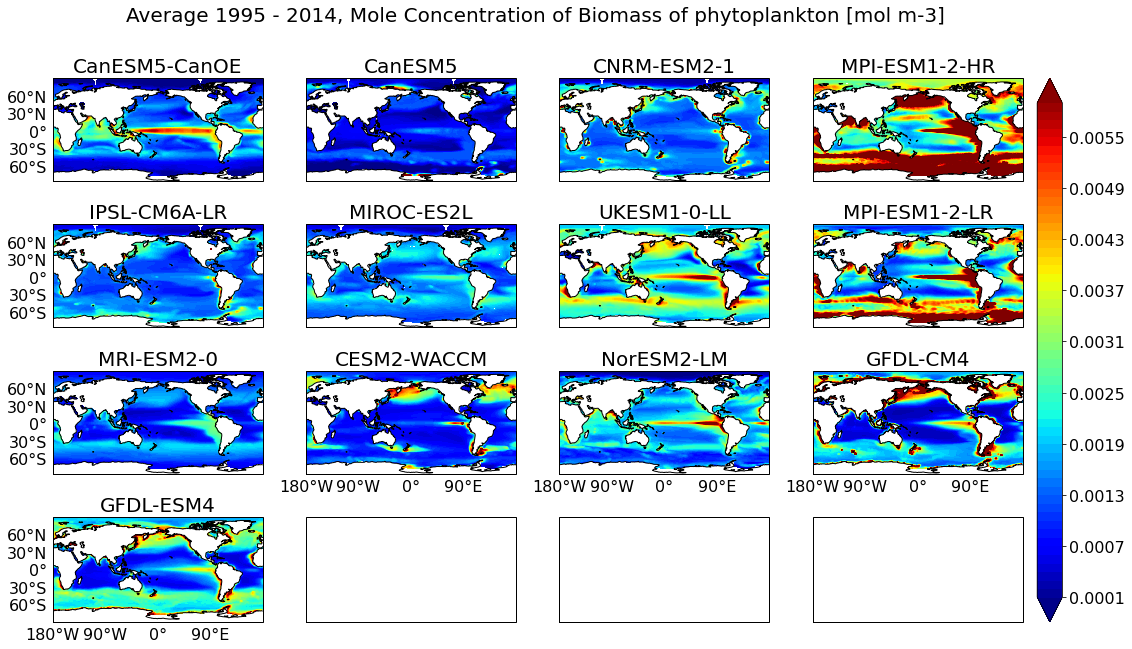

In [83]:
%%time



fig = plt.figure(figsize=(24, 10))

# from mpl_toolkits.axes_grid1 import AxesGrid
# from cartopy.mpl.geoaxes import GeoAxes
# import matplotlib.ticker as mticker
# from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
# from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
# import cartopy.crs as ccrs

n_c = 4
n_r = 4
n_t=len(new_models)


projection = ccrs.PlateCarree(central_longitude=180)
axes_class = (GeoAxes,dict(map_projection=projection))
axgr = AxesGrid(fig, 111, axes_class=axes_class, nrows_ncols=(4, 4),
                    axes_pad=0.6,
                    cbar_location='right',
                    cbar_mode='single',
                    cbar_pad=0.2,
                    cbar_size='3%',
                    share_all = False,
                    label_mode='')  # note the empty label_mode

#projection = ccrs.PlateCarree(central_longitude=180)
# levels = np.linspace(-0.001, 0.005, 0.02)
vmin = 0
vmax = 0.006
n=60
levels = np.linspace(vmin, vmax, n+1)
cmap = mpl.cm.jet
i = 0
for model in new_models:
    if isinstance(xray2_dic[model], list):
        continue
    else:
        s = regrid_dic1[model]
        ax = list(axgr)[i]
        i = i + 1

        p = ax.contourf(regrid_dic1[model].lon, regrid_dic1[model].lat, s, levels=levels, cmap = cmap, transform=ccrs.PlateCarree(), extend='both')
        ax.coastlines()
        ax.set_title(str(model),fontsize= 20)
    #https://stackoverflow.com/questions/49956355/adding-gridlines-using-cartopy
        gl = ax.gridlines(crs=projection, alpha=0, draw_labels=True)
        gl.xlabels_top = False
        gl.xlocator = mticker.FixedLocator([ 90, 0, -90, -180])
        gl.ylocator = mticker.FixedLocator([-90, -60, -30, 0, 30, 60, 90])
        gl.xformatter = LONGITUDE_FORMATTER
        gl.yformatter = LATITUDE_FORMATTER
        
        if i-1 == (n_c*(n_r-1)): # Adds longitude ranges only to the last subplots that appear at the bottom of plot
            gl.ylabels_left = True
            gl.ylabels_right=False
            gl.ylabel_style = {'size': 16} # labels = [left,right,top,bottom] # Longitudes
            gl.xlines = True
            gl.xlabel_style = {'size': 16}
        elif i-1==0 or i-1==n_c or i-1==n_c*2 or i-1==n_c*3 or i-1==n_c*4 or i-1==n_c*5 or i-1==n_c*6 or i-1==n_c*7 or i-1==n_c*8:
            gl.ylabels_left = True
            gl.ylabels_right=False
            gl.ylabel_style = {'size': 16} #
            gl.xlabels_bottom = False
        elif i-1 >= n_t-n_c and i-1 != (n_c*(n_r-1)): # Adds longitude ranges only to the last subplots that appear at the bottom of plot
            gl.ylabels_left = False
            gl.ylabels_right=False
            gl.xlines = False
            gl.xlabel_style = {'size': 16}
        else:
            gl.ylabels_left = False
            gl.ylabels_right=False
            gl.ylabel_style = {'size': 16} #
            gl.xlabels_bottom = False
            gl.xlines = False
            if i>n_t:
                plt.close(i)
#        
plt.suptitle('Average 1995 - 2014, Mole Concentration of Biomass of phytoplankton [mol m-3]', fontsize=20) 
# cb = axgr.cbar_axes[0].colorbar(p)
cb = mpl.colorbar.ColorbarBase(axgr.cbar_axes[0], cmap = cmap, boundaries = levels, extend='both')
cb.ax.tick_params(labelsize=16)


plt.savefig('phyc_start.png', dpi=600)
# model order

/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:58: MatplotlibDeprecationWarning: Since 3.2, mpl_toolkits's own colorbar implementation is deprecated; it will be removed two minor releases later.  Set the 'mpl_toolkits.legacy_colorbar' rcParam to False to use Matplotlib's default colorbar implementation and suppress this deprecation warning.


/srv/conda/envs/notebook/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:388: MatplotlibDeprecationWarning: 
The 'inframe' parameter of draw() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use Axes.redraw_in_frame() instead. If any parameter follows 'inframe', they should be passed as keyword, not positionally.
  inframe=inframe)


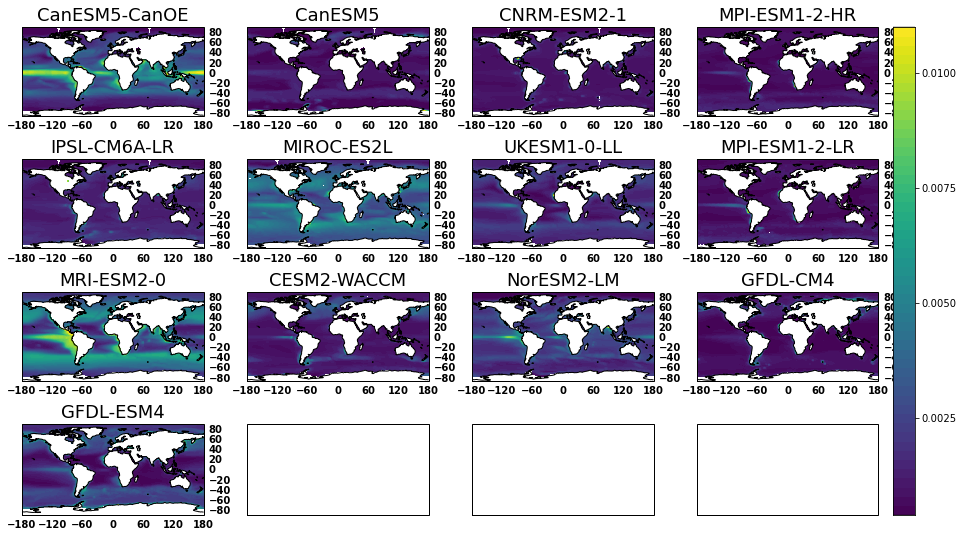

In [54]:
fig = plt.figure(figsize=(16, 10))
# grid = ImageGrid(fig, 111,          # as in plt.subplot(111)
#                  nrows_ncols=(4,4),
# #                  axes_pad=0.15,
# #                  share_all=True,
# #                  cbar_location="right",
# #                  cbar_mode="single",
# #                  cbar_size="7%",
# #                  cbar_pad=0.15,
#                  projection=ccrs.PlateCarree()
#                  )
from mpl_toolkits.axes_grid1 import AxesGrid
from cartopy.mpl.geoaxes import GeoAxes
projection = ccrs.PlateCarree()
axes_class = (GeoAxes,dict(map_projection=projection))
axgr = AxesGrid(fig, 111, axes_class=axes_class, nrows_ncols=(4, 4),
                    axes_pad=0.6,
                    cbar_location='right',
                    cbar_mode='single',
                    cbar_pad=0.2,
                    cbar_size='3%',
                    label_mode='')  # note the empty label_mode


i = 0
for model in new_models:
#     model = 0
    
    if isinstance(xray2_dic[model], list):
        continue
    else:
        s = regrid_dic1[model]
#         ax = plt.subplot(n_r,n_c,i)
        ax = list(axgr)[i]
        i = i + 1
        p = ax.contourf(regrid_dic2[model].lon, regrid_dic2[model].lat, s, 60,transform=ccrs.PlateCarree())
        ax.coastlines(resolution='110m')
        ax.set_title(str(model),fontsize= 18)
    #https://stackoverflow.com/questions/49956355/adding-gridlines-using-cartopy

        gl = ax.gridlines(crs=ccrs.PlateCarree(), alpha=0, draw_labels=True)
        gl.xlabels_top = False
        gl.ylabels_left = False
        gl.ylabels_right=True
        gl.ylabel_style = {'color': 'black', 'weight': 'bold'}
        gl.xlines = True
#         gl.xlocator = mticker.FixedLocator([120, 140, 160, 180, -160, -140, -120])
#         gl.ylocator = mticker.FixedLocator([0, 20, 40, 60])
#         gl.xformatter = LONGITUDE_FORMATTER
#         gl.yformatter = LATITUDE_FORMATTER
        gl.xlabel_style = {'color': 'black', 'weight': 'bold'}
#     gl.ylabel_style = {'color': (25,25,112), 'weight': 'bold'}
axgr.cbar_axes[0].colorbar(p)



/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:30: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


NameError: name 'Basemap' is not defined

<Figure size 1152x720 with 0 Axes>

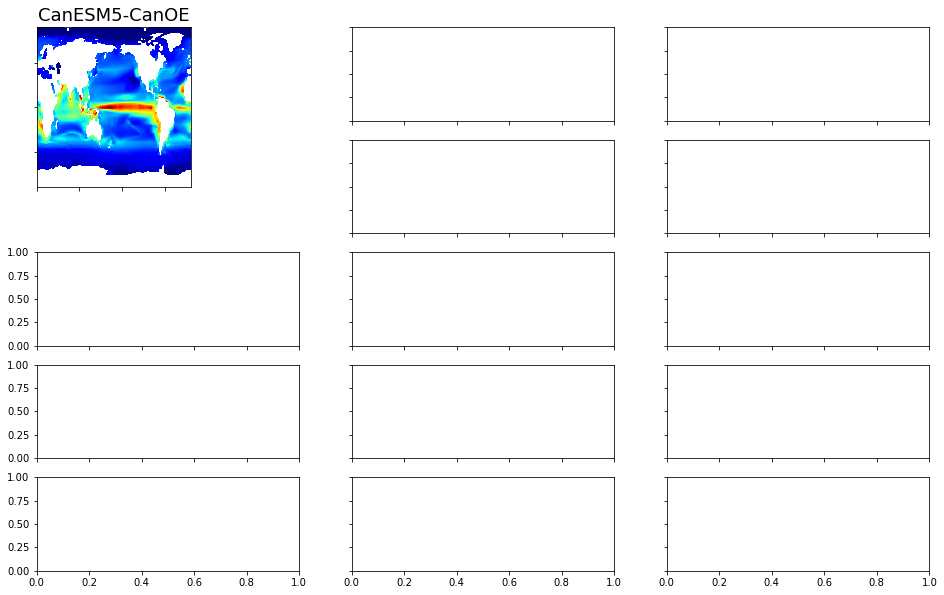

In [28]:
%%time
# 
# START of period  Behzad
# P_latS=regrid_dic1[model].lat
n_t=len(new_models) # we have 8 new_models
n_c = np.floor(n_t/3)+1  #rows  needs to be an int
n_c = n_c.astype(int)
#n_c = 3 # rows
n_r = 3 # columns
parallels = np.arange(0.,81,10.)
meridians = np.arange(10.,351.,20.)
P_proj='cyl'; P_lon0=210.; P_latN=90.; P_latS=-90.;
#fig, axes = plt.subplots(nrows=n_c, ncols=n_r, figsize=(8.5, 5))

plt.figure(figsize=(16, 10))




fig, axes = plt.subplots(nrows=n_c, ncols=n_r, sharex=True, sharey=True,figsize=(16, 10))

i = 0
for model in new_models:
    i = i + 1
    if isinstance(xray2_dic[model], list):
        continue
    else:
        s = regrid_dic1[model]
        ax = plt.subplot(n_r,n_c,i)
        #         im = plt.pcolormesh(regrid_dic2[model].lon, regrid_dic2[model].lat, s, cmap=plt.cm.RdBu_r)
        im = plt.pcolormesh(regrid_dic2[model].lon, regrid_dic2[model].lat, s, cmap=plt.cm.jet)
#         im.set_clim(0, 0.006)
        #ax.title.set_text(str(model))
        ax.set_title(str(model),fontsize= 18)
        ax.set_yticklabels([])
        ax.set_xticklabels([])
        
        m = Basemap( projection=P_proj, lon_0=210., llcrnrlon=0., llcrnrlat=P_latS, urcrnrlon=360., urcrnrlat=P_latN)

        m.drawcoastlines()  
        if i-1 == (n_c*(n_r-1)): # Adds longitude ranges only to the last subplots that appear at the bottom of plot
            m.drawparallels(np.arange(P_latS, P_latN+0.001, 30.),labels=[True,False,False,False], linewidth=0.01, color='k', fontsize=16) # labels = [left,right,top,bottom] # Latitutes
            m.drawmeridians(np.arange(0,361,90.),labels=[False,False,False,True], linewidth=0.01, color='k', fontsize=16) # labels = [left,right,top,bottom] # Longitudes
        elif i-1==0 or i-1==n_c or i-1==n_c*2 or i-1==n_c*3 or i-1==n_c*4 or i-1==n_c*5 or i-1==n_c*6 or i-1==n_c*7 or i-1==n_c*8:
            m.drawparallels(np.arange(P_latS, P_latN+0.001, 30.),labels=[True,False,False,False], linewidth=0.01, color='k', fontsize=16) # labels = [left,right,top,bottom] # Latitutes
        elif i-1 >= n_t-n_c and i-1 != (n_c*(n_r-1)): # Adds longitude ranges only to the last subplots that appear at the bottom of plot
            m.drawmeridians(np.arange(0,361,90.),labels=[False,False,False,True], linewidth=0.01, color='k', fontsize=16) # labels = [left,right,top,bottom] # Longitudes
        else:
            m.drawparallels(np.arange(P_latS, P_latN+0.001, 30.),labels=[False,False,False,False], linewidth=0.01, color='k', fontsize=16) # labels = [left,right,top,bottom] # Latitutes
            m.drawmeridians(np.arange(0,361,90.),labels=[False,False,False,False], linewidth=0.01, color='k', fontsize=16) # labels = [left,right,top,bottom] # Longitudes
            if i>n_t:
                plt.close(i)

            
# fig.subplots_adjust(bottom=0.1, top=0.9, left=0.1, right=0.8, wspace=0.15, hspace=0.15) # the amount of height/width reserved for space between subplots
#plt.suptitle('Dissolved Nitrate Concentration [mol m-3]', fontsize=18)  
# plt.suptitle('Average 1995 - 2014, Mole Concentration of Biomass of phytoplankton [mol m-3]', fontsize=18) 
# plt.suptitle('Average 1995 - 2014, Mole Concentration of Biomass of zooplankton [mol m-3]', fontsize=18) 
# plt.suptitle('Average 1995 - 2014, Primary Organic Carbon Production by All Types of Phytoplankton [mol m-2 s-1]', fontsize=18) 
# plot_ranges=[0,0.006]
#plt.suptitle('Average 1995 - 2014, Dissolved Phosphate Concentration [mol m-3]', fontsize=18) 
#plt.suptitle('Average 1995 - 2014, Dissolved Iron Concentration [mol m-3]', fontsize=18) 
# plt.suptitle('Average 1995 - 2014, Downward Flux of Particulate Organic Carbon [mol m-2 s-1]', fontsize=18) 
# plt.suptitle('Average 1995 - 2014, Surface Downward Flux of Total CO2 [kg m-2 s-1]', fontsize=18) 
# plt.suptitle('Average 1995 - 2014, Surface Aqueous Partial Pressure of CO2 [Pa]', fontsize=18) 
# plt.suptitle('Average 1995 - 2014, Surface Dissolved Iron Concentration [mol m-3]', fontsize=18) 
# plt.suptitle('Average 1995 - 2014, Surface Dissolved Nitrate Concentration [mol m-3]', fontsize=18) 
plt.suptitle('Average 1995 - 2014, Surface Total Dissolved Inorganic Silicon Concentration [mol m-3]', fontsize=18) 

#plt.suptitle('Average 1995 - 2014, Mole Concentration of Diatoms Expressed as Carbon in Sea Water [mol m-3]', fontsize=18) 
# plt.suptitle('Average 1995 - 2014, Mole Concentration of Mesozooplankton Expressed as Carbon in Sea Water [mol m-3]', fontsize=18) 
# plt.tight_layout()

## from Behzad's CMIP5
# plot_ranges=[[0,0.006], [0,8e-7],  [0, 0.0008],  [0,0.006],  [0,2], [0,1e-6], [0,1.6e-7],   [-12,12],   [300,450],    [0,3.8e-6], [0,0.015], [0,0.06], [0,32], [0,300], [-120,120],[300,450],[300,450]]

#cb_ax = fig.add_axes([0.83, 0.1, 0.02, 0.8])
plt.set_cmap('jet')


#cb_ax = fig.add_axes([0.83, 0.1, 0.02, 0.8])
plt.subplots_adjust(left=0.05, bottom=0.05, right=0.93, top=0.92, hspace=0.01, wspace=0.02) # the amount of height/width reserved for space between subplots
cb_ax = fig.add_axes([0.94, 0.05, 0.015, 0.87]) # [right,bottom,width,height]
# cb_ax = fig.add_axes([0.9, 0.1, 0.02, 0.8])  # [right,bottom,width,height]
cbar = fig.colorbar(im, cax=cb_ax, extend='both')
# plt.colorbar(extend='both')
# plt.tight_layout()
#plt.colorbar()
#ax.title.set_text(str(model), fontsize=20)
#plt.title('int_PP [mol/yr/s]', fontsize=18)
#plt.title('SST [°C]', fontsize=18)
#x_pos = 0.2
#y_pos = 0.8
#plt.text(x_pos, y_pos, "text on plot")
plt.savefig('phyc_start.png', dpi=600)
# plt.savefig('zooc_start.png', dpi=600)
# plt.savefig('esp100_start.png', dpi=600)
# plt.savefig('fgco2_start.png', dpi=600)
# plt.savefig('spco2_start.png', dpi=600)
# plt.savefig('dfeos_start.png', dpi=600)
# plt.savefig('no3os_start.png', dpi=600)
# plt.savefig('sios_start.png', dpi=600)

ValueError: Unable to create a colorbar axes as not all parents share the same figure.

/srv/conda/envs/notebook/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:388: MatplotlibDeprecationWarning: 
The 'inframe' parameter of draw() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use Axes.redraw_in_frame() instead. If any parameter follows 'inframe', they should be passed as keyword, not positionally.
  inframe=inframe)
/srv/conda/envs/notebook/lib/python3.7/site-packages/cartopy/io/__init__.py:260: DownloadWarning: Downloading: http://naciscdn.org/naturalearth/110m/physical/ne_110m_coastline.zip
  warnings.warn('Downloading: {}'.format(url), DownloadWarning)


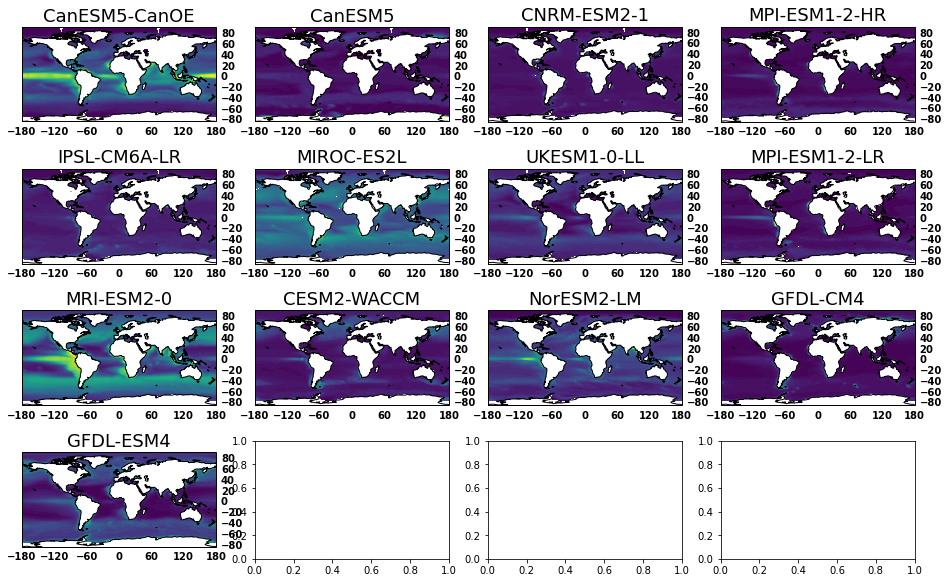

In [11]:
%%time
# import cartopy.mpl.ticker as cticker
import matplotlib.ticker as mticker
# from mpl_toolkits.axes_grid1 import AxesGrid
# from cartopy.mpl.geoaxes import GeoAxes
from mpl_toolkits.axes_grid1 import ImageGrid

# 
# START of period  Behzad
# P_latS=regrid_dic1[model].lat
n_t=len(new_models) # we have 8 new_models 13
n_c = np.floor(n_t/4)+1  #rows  needs to be an int
n_c = n_c.astype(int)
#n_c = 3 # rows
n_r = 4 # columns
# parallels = np.arange(0.,81,10.)
# meridians = np.arange(10.,351.,20.)
# P_proj='cyl'; P_lon0=210.; P_latN=90.; P_latS=-90.;
#fig, axes = plt.subplots(nrows=n_c, ncols=n_r, figsize=(8.5, 5))

# fig = plt.figure(figsize=(16, 10))
fig, axes = plt.subplots(nrows=n_r, ncols=n_c,figsize=(16, 10))
# grid = ImageGrid(fig, 111,          # as in plt.subplot(111)
#                  nrows_ncols=(n_c,n_r),
#                  axes_pad=0.15,
#                  share_all=True,
#                  cbar_location="right",
#                  cbar_mode="single",
#                  cbar_size="7%",
#                  cbar_pad=0.15,
#                  )

# projection = ccrs.PlateCarree()
# axes_class = (GeoAxes,dict(map_projection=projection))
# axgr = AxesGrid(fig, 111, axes_class=axes_class, nrows_ncols=(4, 4),
#                     axes_pad=0.6,
#                     cbar_location='right',
#                     cbar_mode='single',
#                     cbar_pad=0.2,
#                     cbar_size='3%',
#                     label_mode='')  # note the empty label_mode


i = 0
for model in new_models:
#     model = 0
    i = i + 1
    if isinstance(xray2_dic[model], list):
        continue
    else:
        s = regrid_dic1[model]
#         ax = plt.subplot(n_r,n_c,i)
        ax = plt.subplot(n_r,n_c,i, projection=ccrs.PlateCarree())
#         p = plt.pcolormesh(regrid_dic2[model].lon, regrid_dic2[model].lat, s, cmap=plt.cm.jet)
        p = plt.contourf(regrid_dic2[model].lon, regrid_dic2[model].lat, s, 60,transform=ccrs.PlateCarree())
#         ax1.coastlines('50m')
        ax.coastlines(resolution='110m')
#         ax.gridlines()  # gridlines off, but labels???
#         ax.gridlines(draw_labels=True)
        ax.set_title(str(model),fontsize= 18)
    #https://stackoverflow.com/questions/49956355/adding-gridlines-using-cartopy
#         gl = ax.gridlines()
        gl = ax.gridlines(crs=ccrs.PlateCarree(), alpha=0, draw_labels=True)
        gl.xlabels_top = False
        gl.ylabels_left = False
        gl.ylabels_right=True
        gl.ylabel_style = {'color': 'black', 'weight': 'bold'}
        gl.xlines = True
#         gl.xlocator = mticker.FixedLocator([120, 140, 160, 180, -160, -140, -120])
#         gl.ylocator = mticker.FixedLocator([0, 20, 40, 60])
#         gl.xformatter = LONGITUDE_FORMATTER
#         gl.yformatter = LATITUDE_FORMATTER
        gl.xlabel_style = {'color': 'black', 'weight': 'bold'}
#     gl.ylabel_style = {'color': (25,25,112), 'weight': 'bold'}
# axgr.cbar_axes[0].colorbar(p)
# fig.colorbar(p, ax=axes.ravel().tolist())
# cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
# fig.colorbar(p, cax=cbar_ax)

# # Colorbar
# ax.cax.colorbar(p)
# ax.cax.toggle_label(True)

fig.colorbar(p, ax=axes.ravel().tolist())

plt.show()
